In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scienceplots

In [2]:
#Model Parameters
N = 20  # Number of lattice sites (only divisible by 4 allowed)
J = 1.0  # Hopping parameter
W = 4  # Modulation strength
beta = (1 + np.sqrt(5)) / 2  # Incommensurate parameter (golden ratio)
phi = 0  # Phase

# Time array
num_steps = 1000
total_time = 0.3
times = np.linspace(0, total_time, num_steps)

In [3]:
#define different ramps
def exp_ramp(t):
    return (np.exp(t/ total_time) -1) / (np.exp(1) - 1)

def lin_ramp(t):
    return t / total_time

#function x^3 with saddlepoint at height such that W*height = 2

from scipy.optimize import fsolve

# Define the system of equations
def equations(vars):
    a, b = vars
    eq1 = 2/W - a* b**3
    eq2 = 1 - a* (1-b)**3 - 2/W
    return [eq1, eq2]

# Initial guess
x_initial_guess = 1
y_initial_guess = 1
guess = [x_initial_guess, y_initial_guess]

# Solve the system of equations
solution = fsolve(equations, guess)

def saddlepoint_ramp(t):
    
    a = solution[0]
    b= solution[1]
    
    return a*(t/total_time-b)**3 + 2/W


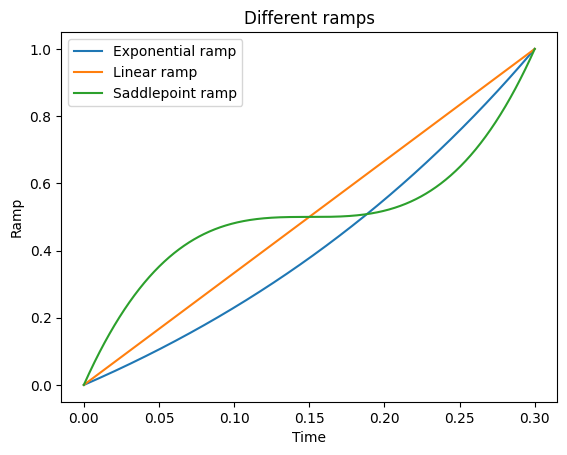

In [4]:
#plot all the ramps
fig, ax = plt.subplots()
ax.plot(times, exp_ramp(times), label="Exponential ramp")
ax.plot(times, lin_ramp(times), label="Linear ramp")
ax.plot(times, saddlepoint_ramp(times), label="Saddlepoint ramp")
ax.set_xlabel("Time")
ax.set_ylabel("Ramp")
ax.set_title("Different ramps")
ax.legend()
plt.show()

In [5]:
def aubry_andre_model(N, W, J, beta, phi, t, ramp):
    # Construct the Hamiltonian matrix
    H = np.zeros((N, N))

    # Onsite terms
    for n in range(N):
        H[n, n] = W * np.cos(2 * np.pi * beta * n + phi) *ramp(t)

    # Nearest-neighbor hopping terms
    for n in range(N - 1):
        H[n, n + 1] = -J
        H[n + 1, n] = -J

    return H

def time_evolution(H, psi, t):
    #U = expm(-1j * H * t)
    #instead of using the matrix exponential, we can use the eigenvectors and eigenvalues of the Hamiltonian
    #to calculate the time evolution of the wavefunction
    eigenvalues, eigenvectors = np.linalg.eig(H)
    U = np.dot(eigenvectors, np.dot(np.diag(np.exp(-1j * eigenvalues * t)), np.conj(eigenvectors).T))
    psi_t = np.dot(U, psi)
    return psi_t


In [6]:
#Create the initial state as an Eigenstate of the System with W=0
psi0 = np.zeros(N)
Eigenresults = np.linalg.eig(aubry_andre_model(20, 0, 1, beta, phi, 0, lin_ramp))

psi_t = np.zeros((num_steps + 1, N), dtype=complex)
psi_t[0] = Eigenresults[1][:,2]

In [7]:
#Calculate Wavefunction at each time step
def calculate_wavefunction(N, W, J, beta, phi, times, ramp):
    for i, t in enumerate(times):
        # Construct the Hamiltonian
        H = aubry_andre_model(N, W, J, beta, phi, t, ramp)

        psi_t[i+1] = time_evolution(H, psi_t[i], total_time / num_steps)
    
    return psi_t

In [9]:
#calculate the wavefunction for each ramp
psi_exp = calculate_wavefunction(N, W, J, beta, phi, times, exp_ramp)
psi_lin = calculate_wavefunction(N, W, J, beta, phi, times, lin_ramp)
psi_sad = calculate_wavefunction(N, W, J, beta, phi, times, saddlepoint_ramp)


In [8]:
#make a 2d plot with color map
def plot_probability_density(psi_t):
    fig, ax = plt.subplots()
    #make figure background white
    ax.pcolormesh(np.linspace(1,N,N),times,np.abs(psi_t[:-1,:]) ** 2, cmap='viridis')
    #add colorbar
    cbar = plt.colorbar(ax.pcolormesh(np.linspace(1,N,N),times,np.abs(psi_t[:-1,:]) ** 2, cmap="viridis"))
    #add colorbar label
    cbar.set_label('Probability density')
    ax.set_xlabel('Site')
    ax.set_ylabel('Time')
    ax.set_title('Probability density')
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Site")
    ax.set_ylabel("Time")
    ax.set_title("Probability density")
    plt.savefig('probability_density.png', dpi=300)
    plt.show()

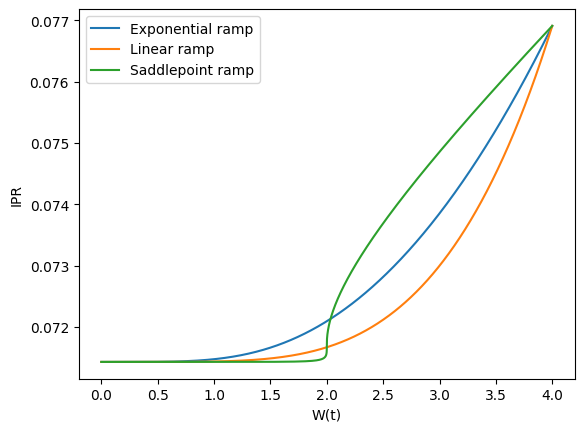

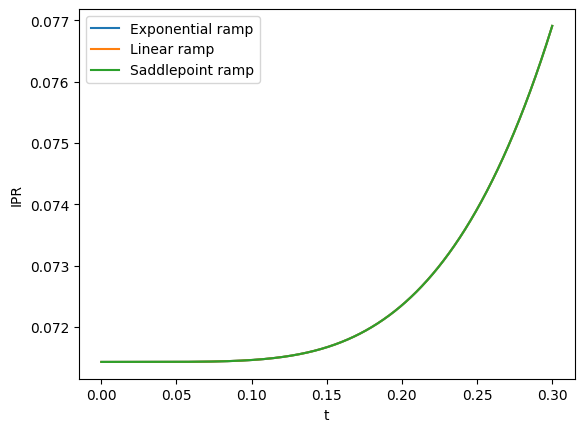

In [11]:
#plot the probability density for each ramp
#plot_probability_density(psi_exp)
#plot_probability_density(psi_lin)
#plot_probability_density(psi_sad)

#plot the IPR over W for each of the ramps in one plot
fig, ax = plt.subplots()
ax.plot(W*exp_ramp(times), np.sum(np.abs(psi_exp[:-1,:]) ** 4, axis=1), label="Exponential ramp")
ax.plot(W*lin_ramp(times), np.sum(np.abs(psi_lin[:-1,:]) ** 4, axis=1), label="Linear ramp")
ax.plot(W*saddlepoint_ramp(times), np.sum(np.abs(psi_sad[:-1,:]) ** 4, axis=1), label="Saddlepoint ramp")
ax.set_xlabel("W(t)")
ax.set_ylabel("IPR")
ax.legend()
plt.show()

#plot the IPR over time for each of the ramps in one plot
fig, ax = plt.subplots()
ax.plot(times, np.sum(np.abs(psi_exp[:-1,:]) ** 4, axis=1), label="Exponential ramp")
ax.plot(times, np.sum(np.abs(psi_lin[:-1,:]) ** 4, axis=1), label="Linear ramp")
ax.plot(times, np.sum(np.abs(psi_sad[:-1,:]) ** 4, axis=1), label="Saddlepoint ramp")
ax.set_xlabel("t")
ax.set_ylabel("IPR")
ax.legend()
plt.show()

In [ ]:
#animate time evolution of the probability density
fig, (ax2,ax4) = plt.subplots(ncols=2,figsize=(20/2.54,8/2.54))
ax2.set_position([0.1, 0.13, 0.4, 0.8])
ax4.set_position([0.65, 0.13, 0.3, 0.8])

#same font size for both axes
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax4.tick_params(axis='x', labelsize=8)
ax4.tick_params(axis='y', labelsize=8)

ax2.ylabel = "Probability density"
ax4.set_xlabel("W")
ax4.set_ylabel("IPR")
ax2.set_xlabel("Site")
ax2.set_ylabel("Probability density")

artists = []
IPR = []
W_array = []

for i in range(0,num_steps):
    container = ax2.bar(np.linspace(1, N, N), np.abs(psi_t[i]) ** 2, color="blue")

    W_array.append(W * lin_ramp(times[i]))
    IPR.append(np.sum(np.abs(psi_t[i]) ** 4))
    container += tuple(ax4.plot(W_array,IPR,color = "blue"))

    artists.append(container)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)

#Save the animation as a video
ani.save('bar_animation.mp4', writer='ffmpeg', fps=num_steps/10)

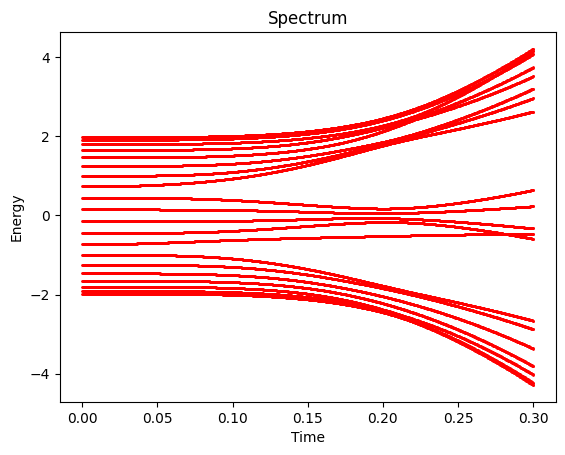

In [14]:
#plot spectrum of the hamiltonian against the time
spectrum = np.zeros((num_steps, N))
for i in range(num_steps):
    spectrum[i] = np.linalg.eig(aubry_andre_model(N, W*lin_ramp(times[i]), J, beta, phi, times[i], lin_ramp))[0]

fig, ax = plt.subplots()
ax.plot(times, spectrum, linestyle='None', marker='o', markersize=1, color='red')
ax.set_xlabel("Time")
ax.set_ylabel("Energy")
ax.set_title("Spectrum")
plt.show()




In [60]:
#2D andre aubry model

#Parameters
N, M = 10,10
W = 100
J = 1
beta = (1+np.sqrt(5))/2
phi_N = 0
phi_M = 0.147917

# Time array
num_steps = 1000
total_time = 30000
times = np.linspace(0, total_time, num_steps)

In [61]:
def aubry_andre_model_2D(N,M, W, J, beta, phi_N,phi_M, t, ramp):
    # Construct the Hamiltonian matrix
    X = N*M
    H = np.zeros((X, X))
    #Onsite terms
    for j in range(X):
        n,m = j//N,j%N
        H[j,j] = W * ramp(t) * np.cos((2 * np.pi * beta * n + phi_N) + np.cos(2 * np.pi * beta * m + phi_M))

    # Nearest-neighbor hopping terms
    for x in range(X):
        possible_neighbours = []
        if x % N != 0:
            possible_neighbours.append(x-1)
        if x % N != N-1:
            possible_neighbours.append(x+1)
        if x // N != 0:
            possible_neighbours.append(x-N)
        if x // N != M-1:
            possible_neighbours.append(x+N)
            
        for y in possible_neighbours:
            H[x,y] = -J
            H[y,x] = -J
        
    return H

def calculate_wavefunction2D(N,M, W, J, beta, phi_N,phi_M, times, ramp):
    for i, t in enumerate(times):
        # Construct the Hamiltonian
        H = aubry_andre_model_2D(N,M, W, J, beta, phi_N ,phi_M, t, ramp)

        psi_t[i+1] = time_evolution(H, psi_t[i], total_time / num_steps)
    
    return psi_t


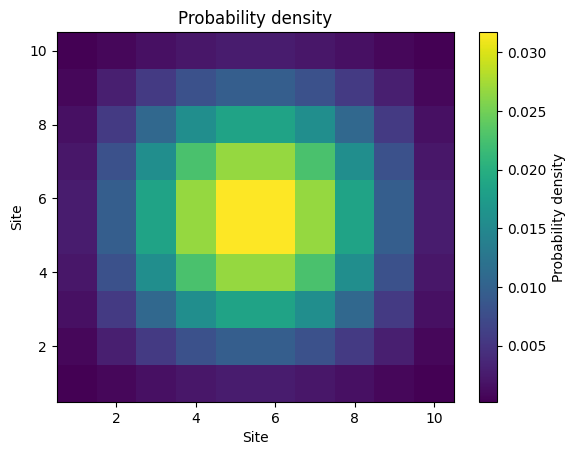

In [62]:
#starting state as an eigenstate of the system with W=0
Eigenresults = np.linalg.eig(aubry_andre_model_2D(N,M, 0, 1, beta, phi_N,phi_M, 0, exp_ramp))

psi_t = np.zeros((num_steps + 1, N*M), dtype=complex)
psi_t[0] = Eigenresults[1][:,0]

#plot psi_0
psi_0 = psi_t[0].reshape((N,M))
fig, ax = plt.subplots()
ax.pcolormesh(np.linspace(1,N,N),np.linspace(1,M,M),np.abs(psi_0) ** 2, cmap='viridis')
cbar = plt.colorbar(ax.pcolormesh(np.linspace(1,N,N),np.linspace(1,M,M),np.abs(psi_0) ** 2, cmap="viridis"))
cbar.set_label('Probability density')
ax.set_xlabel('Site')
ax.set_ylabel('Site')
ax.set_title('Probability density')
plt.show()

In [63]:
calculate_wavefunction2D(N,M, W, J, beta, phi_N,phi_M, times, lin_ramp)

array([[-0.0144315 +0.j        ,  0.02769384+0.j        ,
        -0.03871259+0.j        , ..., -0.03871259+0.j        ,
         0.02769384+0.j        , -0.0144315 +0.j        ],
       [ 0.00654901+0.01285996j, -0.01256746-0.02467808j,
         0.01756777+0.03449693j, ...,  0.01756777+0.03449693j,
        -0.01256746-0.02467808j,  0.00654901+0.01285996j],
       [ 0.00890597-0.01248334j, -0.01563329+0.0234965j ,
         0.02239808-0.03392862j, ...,  0.02085346-0.03029743j,
        -0.01548725+0.02232092j,  0.00801984-0.01115575j],
       ...,
       [ 0.00798364-0.00440906j, -0.01334897+0.00569114j,
        -0.0100144 +0.02520572j, ...,  0.00368324+0.00184842j,
        -0.00280789+0.00806821j,  0.00029247-0.00653543j],
       [ 0.00647204-0.0048594j ,  0.01671605-0.00105341j,
        -0.00249232-0.02810001j, ...,  0.00367552-0.00012806j,
         0.00533961-0.00722835j,  0.00444535-0.00444661j],
       [-0.00574206-0.00630014j,  0.01017001+0.01388857j,
        -0.01600635-0.02159147

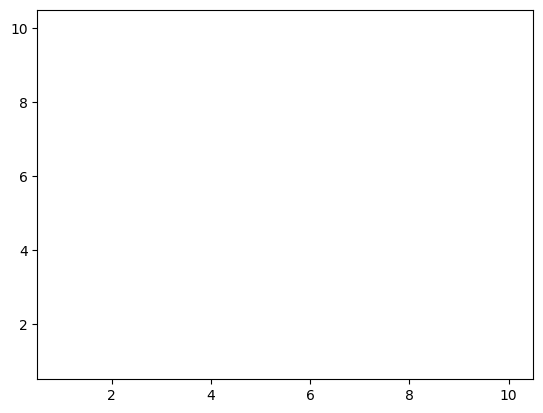

In [64]:
#create a gif of the time evolution of the 2D probability density
artists = []

fig, ax = plt.subplots()

for i in range(0,num_steps):
    psi_reshaped = psi_t[i].reshape((N,M))
    container = ax.pcolormesh(np.linspace(1,N,N),np.linspace(1,M,M),np.abs(psi_reshaped) ** 2, cmap='viridis')
    
    artists.append([container])
ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
ani.save('2D_probability_density.gif', writer='pillow', fps=int(num_steps/10))


